In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callback.tracker import SaveModelCallback

In [2]:
if torch.cuda.is_available():
    print("CUDA Available")
    print(torch.cuda.device_count())
else:
    print("No CUDA")

CUDA Available
4


In [3]:
from torchvision import datasets, transforms, models
import torchvision.transforms as T

In [5]:
from models.backbone import Backbone, EmbeddingNetwork
from models.encoder import EncoderModule
from models.utils.joiner2 import *
from models.utils.losses import Attention_penalty_factor, Generator_loss, CriticLoss
from models.utils.metrics import Accuracy
from models.utils.datasets import *

In [6]:
H = 320
W= 320
bs = 5

# transform = T.Compose([
# T.Resize((H,W)),
# T.ToTensor(),
# T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [6]:
# dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
# print(len(dataset))

In [7]:
# train_size = 40000
# test_size = 10000
# remainder = 0
# dataset.train, dataset.valid, _ = torch.utils.data.random_split(dataset, [train_size, test_size, remainder])

In [8]:
# loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)
# loader.train = torch.utils.data.DataLoader(dataset.train, batch_size=20, shuffle=True)
# loader.valid = torch.utils.data.DataLoader(dataset.valid, batch_size=20, shuffle=True)

In [9]:
# training_dataset = datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)
# validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)
# train_dl = DataLoader(training_dataset,bs=20, device='cuda')
# valid_dl = DataLoader(validation_dataset,bs=20, device='cuda')
# dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')
# training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

In [11]:
model = Joiner(backbone = False, num_classes = 10, bypass=False, hidden_dim=256, batch_size=bs, image_h=H, image_w=W,grid_l=4,penalty_factor="2")

In [12]:
#model

In [13]:
#add_noise = UNet(3,3,bilinear=False)
#add_noise = add_noise.to(device)

In [14]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# model_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)

In [15]:
# gen_criterion = Generator_loss(beta=0.0000001, gamma=0.01,sigma=1)
# gen_optimizer = torch.optim.Adam(add_noise.parameters(), lr = 0.0001)
# gen_lr_scheduler = lr_scheduler.StepLR(gen_optimizer, step_size=6, gamma=0.1)

In [26]:
def get_im_label(im):
    return im

In [28]:
path = untar_data(URLs.CIFAR)
#path = Path.home()/'Luiz/gan_attention/data'

transforms = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# dld = ImageDataLoaders.from_folder(path, 
#                                     train='train',
#                                     valid_pct=0.2,
#                                     item_tfms=None, 
#                                     batch_tfms=transform, 
#                                     bs=10,  
#                                     device='cuda')

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transforms)

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=Pipeline[get_im_label, parent_label],
                 item_tfms=Resize(H,W),
                 batch_tfms=transforms)

dloader = data.dataloaders(path,bs=bs,device='cuda') 

TypeError: 'type' object is not subscriptable

In [17]:
print("Number of Training Images:", len(dloader.train)*bs)
print("Number of Validation Images:", len(dloader.valid)*bs)
print("Batch Size:", bs)

Number of Training Images: 48000
Number of Validation Images: 12000
Batch Size: 5


48000

In [23]:
dloader.train_ds

(#48000) [(PILImage mode=RGB size=32x32, TensorCategory(8)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(2)),(PILImage mode=RGB size=32x32, TensorCategory(3)),(PILImage mode=RGB size=32x32, TensorCategory(2)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(2)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(3))...]

In [18]:
save = SaveModelCallback(monitor='accuracy', fname='Encoder')

In [19]:
model_path = Path.home()/'Luiz/saved_models'
learn = Learner(dloader, model, loss_func=CriticLoss(), metrics=[Accuracy], cbs=[save], model_dir=model_path)

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

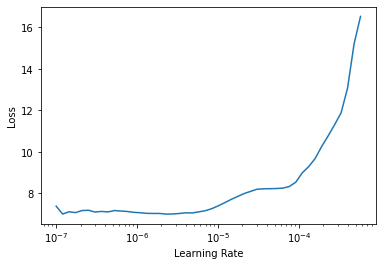

In [21]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(1,2e-7)

AssertionError: 

In [ ]:
#learn.export(model_path/"Untrained_model.pkl")